## Model Training: LSTM

In [1]:
import gc
import sys
sys.path.append('../')
sys.path.append('../../../')

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from scipy import signal
from scipy.signal import resample, hilbert
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import earthquake_detection.architectures as architectures
import earthquake_detection.training_utils as training_utils

plt.ioff() # Turn off matplotlib interactive mode. Prevents  memory leakage.

2025-01-24 11:09:11.673655: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load extracted raw signals
raw_signals = np.load('../../../data/STEAD/extracted_raw_signals_subsample_100000.npy')

# Load metadata
metadata = pd.read_feather('../../../data/STEAD/extracted_metadata_subsample_100000.feather')
metadata = metadata.reset_index()

In [3]:
raw_signals.shape

(100000, 6000, 3)

In [4]:
raw_signals[0][:,2]

array([-0.        ,  0.00024294,  0.00068383, ...,  0.00162756,
        0.00026638,  0.        ], dtype=float32)

In [5]:
metadata['label'] = [1 if label=='earthquake_local' else 0 for label in metadata['trace_category']]
classifier_labels = metadata['label'].values

In [6]:
def hilbert_transform_rolling_avg(raw_signal, resampled=True):
    sos = signal.butter(4, (1,49.9), 'bandpass', fs=100, output='sos') # filter signal from 1-50 Hz, 4th order filter
    filtered = signal.sosfilt(sos, raw_signal[:,2]) # use only z-axis signal component
    analytic_signal = hilbert(filtered) # apply hilbert transform to get signal envelope
    amplitude_envelope = np.abs(analytic_signal) # get only positive envelope
    env_series = pd.Series(amplitude_envelope) # convert to a series to be compatible with pd.Series rolling mean calc
    rolling_obj = env_series.rolling(200) # 2-second rolling mean (100 Hz * 2 sec = 200 samples)
    rolling_average = rolling_obj.mean()
    rolling_average_demeaned = rolling_average[199:] - np.mean(rolling_average[199:])
    rolling_average_padded = np.pad(rolling_average_demeaned, (199,0), 'constant', constant_values=(list(rolling_average_demeaned)[0])) # pad to remove nans created by rolling mean
    if resampled:
        return signal.resample(rolling_average_padded, 300) # resample signal from 6000 samples to 300 to reduce size
    else:
        return rolling_average_padded

In [7]:
# For demonstration/plotting purposes only
signal_envelopes = np.array([hilbert_transform_rolling_avg(raw_signal, resampled=False) for raw_signal in raw_signals[0:100]])

In [8]:
# These are the envelopes that will be used for model training
signal_envelopes_resamp = np.array([hilbert_transform_rolling_avg(raw_signal, resampled=True) for raw_signal in raw_signals])

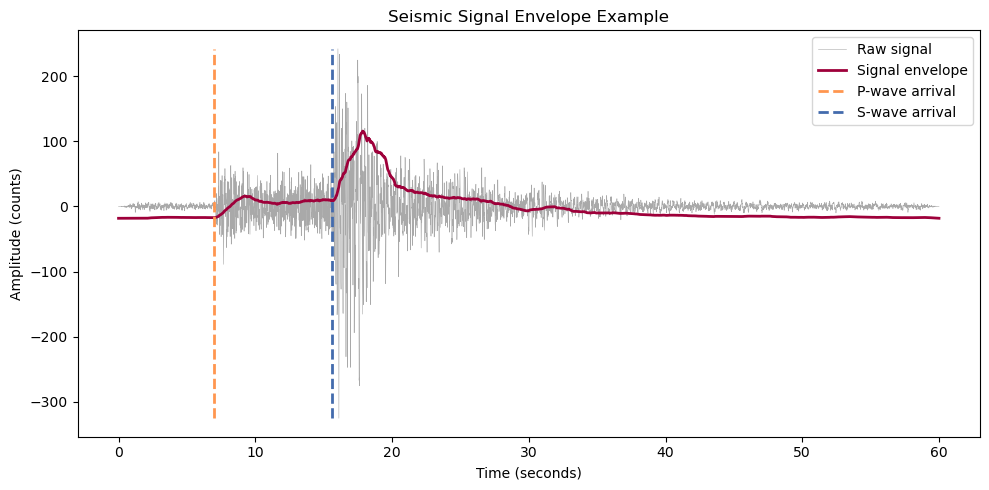

In [9]:
i = 57
fig, ax = plt.subplots(1,1,figsize=(10,5))
sig = raw_signals[i][:,2]
ax.plot(np.linspace(0,60,6000), sig, color='darkgrey', linewidth=0.4, label='Raw signal')
ax.plot(np.linspace(0,60,6000), signal_envelopes[i], color='xkcd:cranberry', linewidth=2, label='Signal envelope')
p_wave = metadata.iloc[i]['p_arrival_sample']
s_wave = metadata.iloc[i]['s_arrival_sample']
ax.vlines(p_wave/100.0, sig.min(), sig.max(), color='xkcd:pastel orange', linewidth=2, linestyle='--', label='P-wave arrival')
ax.vlines(s_wave/100.0, sig.min(), sig.max(), color='xkcd:french blue', linewidth=2, linestyle='--', label='S-wave arrival')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Amplitude (counts)')
ax.set_title('Seismic Signal Envelope Example')
ax.legend()
plt.tight_layout()

In [10]:
earthquakes_indices = np.array(list(metadata[metadata['trace_category']=='earthquake_local'].index))
raw_signals_earthquakes_only = raw_signals[earthquakes_indices]
envelopes_earthquakes_only = signal_envelopes_resamp[earthquakes_indices]
metadata_earthquakes_only = metadata[metadata['trace_category']=='earthquake_local']

In [11]:
signal_envelopes_resamp = np.reshape(signal_envelopes_resamp, (signal_envelopes_resamp.shape[0], 1, signal_envelopes_resamp.shape[1]))
envelopes_earthquakes_only = np.reshape(envelopes_earthquakes_only, (envelopes_earthquakes_only.shape[0], 1, envelopes_earthquakes_only.shape[1]))

In [12]:
def build_compile_classification_lstm(input_shape, learning_rate=1e-5, loss='binary_crossentropy', metrics=['accuracy']):
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(64, input_shape=input_shape, return_sequences=True),
        tf.keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    return model

In [83]:
    train_labels = []
    for images, labels in train_dataset_c:
        train_labels.append(np.array(labels))
    train_labels = np.concatenate(train_labels)

    test_labels = []
    for _, labels in test_dataset_c:
        test_labels.append(labels.numpy())
    test_labels = np.concatenate(test_labels)

In [90]:
from scipy.stats import mode
most_common_label = mode(train_labels[:,0])[0]
predictions = np.full((len(test_labels)), most_common_label, dtype=int)

In [89]:
train_labels[:,0].shape

(64000,)

In [91]:
predictions.shape

(20000,)

In [131]:
def evaluate_classification_model(trained_model, train_dataset, test_dataset):
    # Fetch labels
    train_labels = []
    for images, labels in train_dataset:
        train_labels.append(np.array(labels))
    train_labels = np.concatenate(train_labels)

    test_labels = []
    for _, labels in test_dataset:
        test_labels.append(labels.numpy())
    test_labels = np.concatenate(test_labels)

    # Get baseline evaluation metrics
    most_common_label = mode(train_labels[:,0])[0]
    predicted_classes_baseline = np.full((len(test_labels)), most_common_label, dtype=int)

    accuracy_base = accuracy_score(test_labels, predicted_classes_baseline)
    precision_base = precision_score(test_labels, predicted_classes_baseline)
    recall_base = recall_score(test_labels, predicted_classes_baseline)
    f1_base = f1_score(test_labels, predicted_classes_baseline)
    baseline_metrics = [accuracy_base, precision_base, recall_base, f1_base]
    print(f'Model baseline accuracy: {accuracy_base}\n Model baseline precision: {precision_base}\n Model baseline recall: {recall_base}\n Model baseline F1 score: {f1_base}')

    # predict the class of each image
    pred_probs = trained_model.predict(test_dataset)
    predicted_classes = (pred_probs > 0.5).astype(int)

    # Get test dataset evaluation metrics
    accuracy = accuracy_score(test_labels, predicted_classes)
    precision = precision_score(test_labels, predicted_classes)
    recall = recall_score(test_labels, predicted_classes)
    f1 = f1_score(test_labels, predicted_classes)
    metrics = [accuracy, precision, recall, f1]
    print(f'Model accuracy: {accuracy}\n Model precision: {precision}\n Model recall: {recall}\n Model F1 score: {f1}')

    # Create confusion matrix
    cm = confusion_matrix(test_labels, predicted_classes) # compare target values to predicted values and show confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not earthquake','earthquake'])

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(test_labels, predicted_classes)
    roc_auc = auc(fpr, tpr)

    # Plot accuracy history, confusion matrix, roc curve
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,6))
    disp.plot(cmap='Blues', ax=ax1, values_format='')
    ax1.set_title('Test Dataset Confusion Matrix')
    ax2_x = np.arange(0, len(metrics))
    metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    bar_container1 = ax2.bar(ax2_x-0.2, baseline_metrics, width=0.39, color='xkcd:cranberry', zorder=5, label='Baseline model metrics')
    bar_container2 = ax2.bar(ax2_x+0.2, metrics, width=0.39, color='xkcd:french blue', zorder=5, label='Model metrics')
    ax2.bar_label(bar_container1, fmt='{:.4f}')
    ax2.bar_label(bar_container2, fmt='{:.4f}')
    ax2.set_xticks(ax2_x)
    ax2.set_xticklabels(metrics_labels)
    ax2.set_ylim([0,1.25])
    ax2.set_ylabel('Metric value')
    ax2.set_title('Test Dataset Metrics')
    ax2.grid(True, alpha=0.2, zorder=0)
    ax2.legend()
    ax3.plot(fpr, tpr, color='xkcd:cranberry', label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax3.plot([0, 1], [0, 1], color='gray', linestyle='--')  # diagonal line (random classifier)
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('Test Dataset ROC Curve')
    ax3.grid(True, alpha=0.2, zorder=0)
    plt.tight_layout()
    plt.show()

Model baseline accuracy: 0.5199
 Model baseline precision: 0.5199
 Model baseline recall: 1.0
 Model baseline F1 score: 0.6841239555233897
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Model accuracy: 0.97135
 Model precision: 0.9718566900393815
 Model recall: 0.9730717445662628
 Model F1 score: 0.9724638377625066


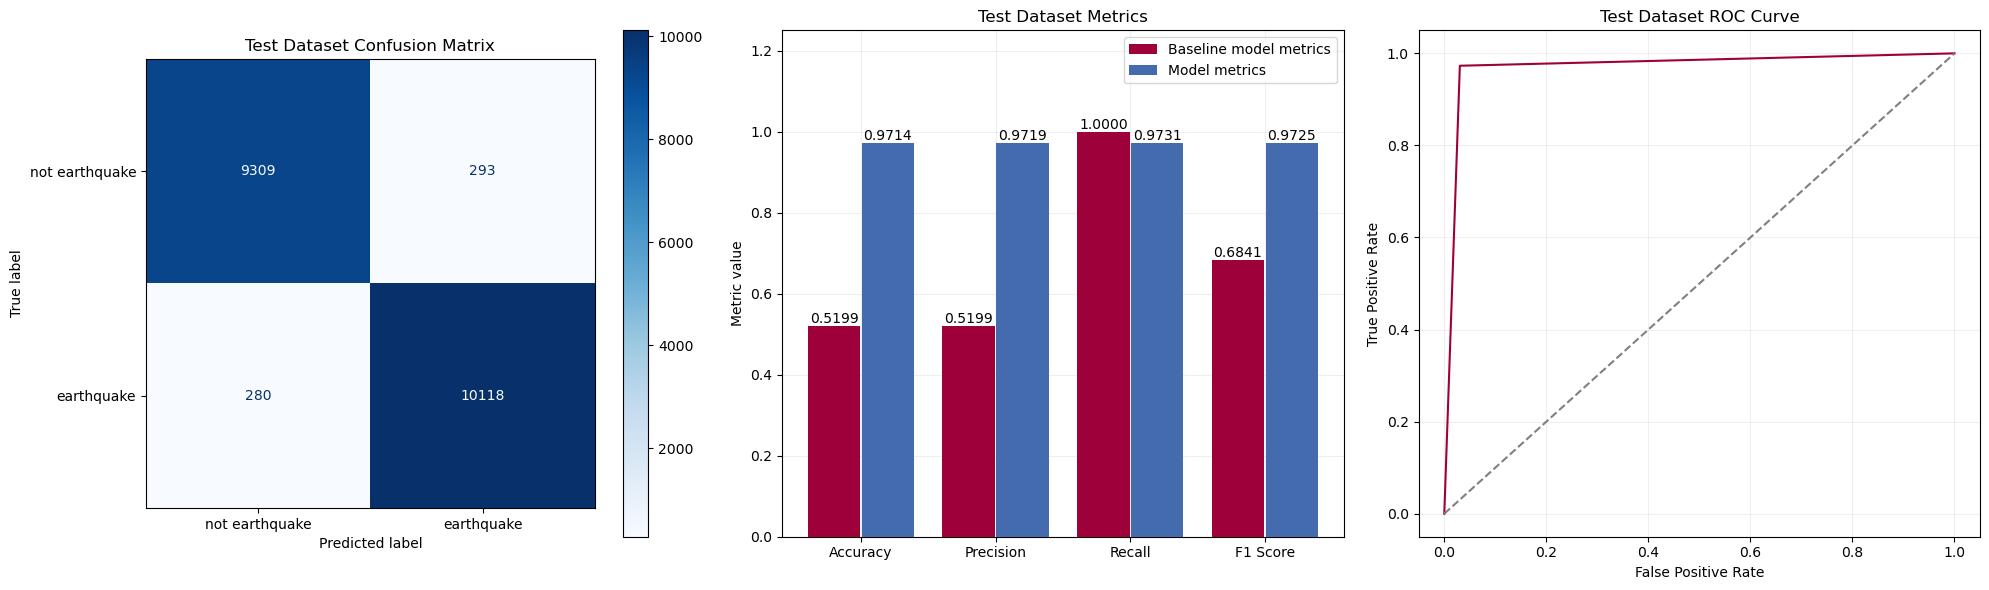

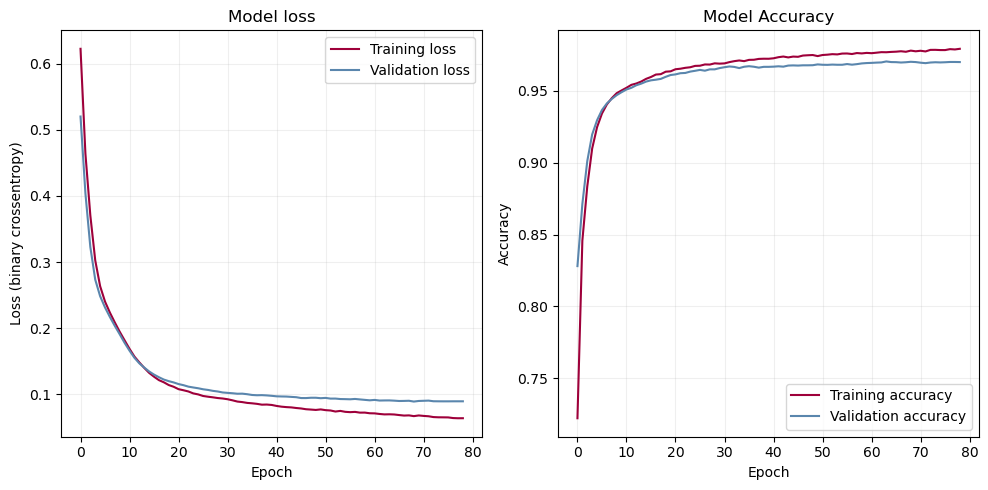

In [132]:
evaluate_classification_model(classifier_model, train_dataset_c, test_dataset_c)
training_utils.plot_training_history(classifier_history)

Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6431 - loss: 0.6632 - val_accuracy: 0.8281 - val_loss: 0.5200 - learning_rate: 1.0000e-05
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8360 - loss: 0.4913 - val_accuracy: 0.8712 - val_loss: 0.4037 - learning_rate: 1.0000e-05
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8764 - loss: 0.3906 - val_accuracy: 0.9010 - val_loss: 0.3228 - learning_rate: 1.0000e-05
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9055 - loss: 0.3155 - val_accuracy: 0.9196 - val_loss: 0.2734 - learning_rate: 1.0000e-05
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9225 - loss: 0.2699 - val_accuracy: 0.9294 - val_loss: 0.2483 - learning_rate: 1.0000e-05
Epoch 6/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9330 - loss: 0.2436 - val_accuracy: 0.9366 - val_loss: 0.2312 - learning_rate: 1.0000e-05
Epoch 7/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s

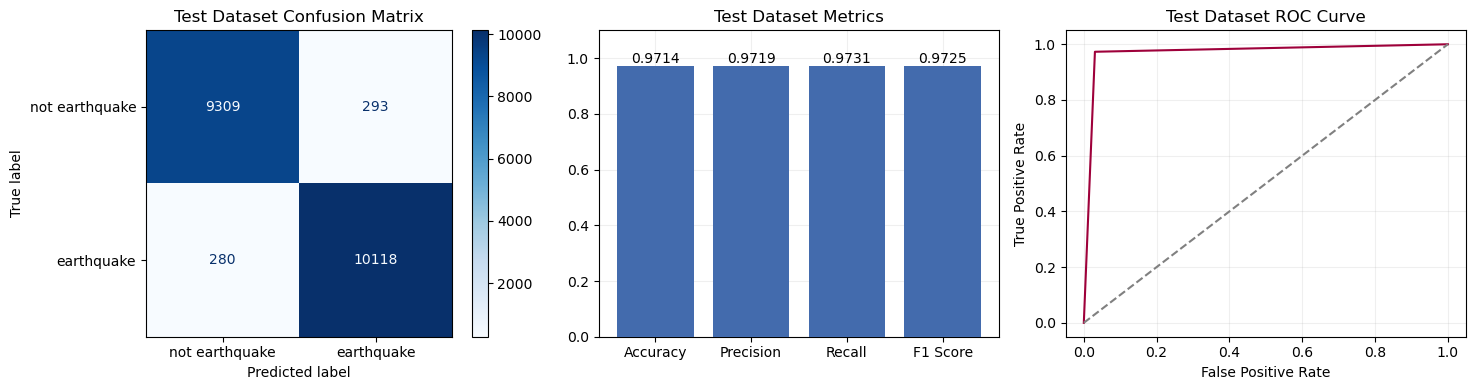

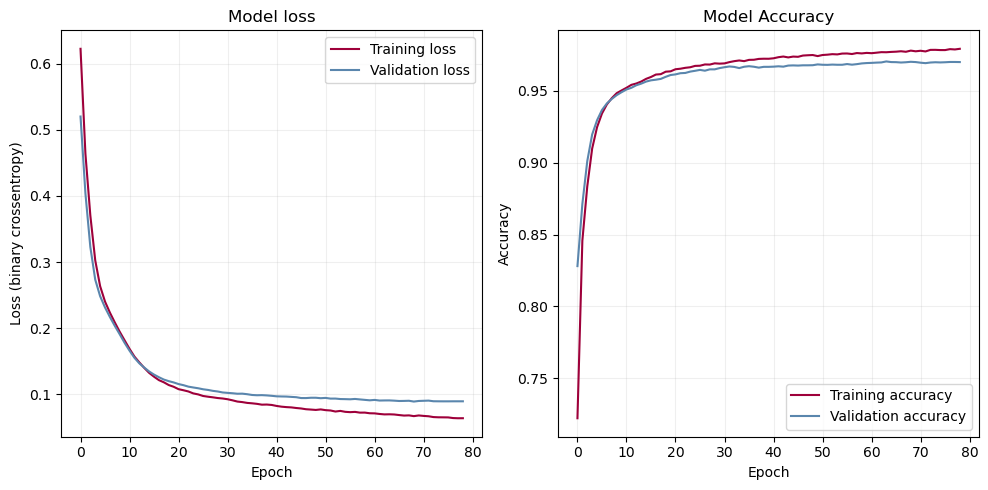

In [16]:
# Set up model callbacks
epochs = 100
callbacks_c = architectures.callbacks_setup(model_tag='lstm_classification', epochs=epochs)

# Fit model
train_dataset_c, val_dataset_c, test_dataset_c = training_utils.prepare_datasets(imgs=signal_envelopes_resamp, labels=classifier_labels, batch_size=32)
input_shape = (signal_envelopes_resamp.shape[1], signal_envelopes_resamp.shape[2])
classifier_model = build_compile_classification_lstm(input_shape=input_shape, learning_rate=1e-5, loss='binary_crossentropy', metrics=['accuracy'])
classifier_history = classifier_model.fit(train_dataset_c, epochs=epochs, callbacks=callbacks_c, validation_data=val_dataset_c)

# Evaluate model and plot results
training_utils.evaluate_classification_model(classifier_model, test_dataset_c)
training_utils.plot_training_history(classifier_history)

In [14]:
def build_compile_regression_lstm(input_shape, learning_rate=1e-4, loss='mse', metrics=['mae']):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(32, input_shape=input_shape, return_sequences=True),
        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    return model

Epoch 1/100


/opt/miniconda3/envs/earthquake-detection/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1043/1043 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.8577 - mae: 1.0179 - val_loss: 0.5657 - val_mae: 0.5674 - learning_rate: 1.0000e-04
Epoch 2/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5909 - mae: 0.5826 - val_loss: 0.5367 - val_mae: 0.5519 - learning_rate: 1.0000e-04
Epoch 3/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5475 - mae: 0.5615 - val_loss: 0.5297 - val_mae: 0.5530 - learning_rate: 1.0000e-04
Epoch 4/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5247 - mae: 0.5509 - val_loss: 0.5055 - val_mae: 0.5375 - learning_rate: 1.0000e-04
Epoch 5/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5198 - mae: 0.5500 - val_loss: 0.5021 - val_mae: 0.5353 - learning_rate: 1.0000e-04
Epoch 6/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5080 - mae: 0.5411 - val_loss: 0.5007 - val_mae: 0.5314 - learning_rate: 1.0000e-04
Epoch 7/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5100 - mae: 0.5426 - val_loss: 0.4903 - val_mae: 0.52

2025-01-24 11:32:58.617465: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 0.4477 - mae: 0.4907
Test data MSE: 0.4609253704547882
Test data MAE: 0.4998800456523895
Getting predictions
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


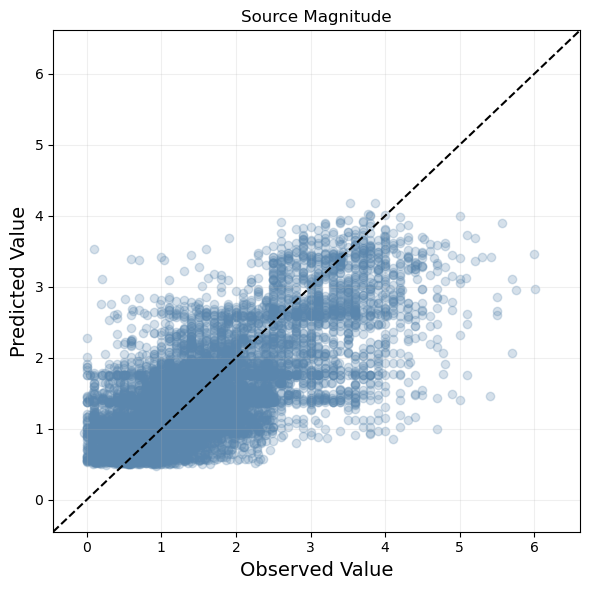

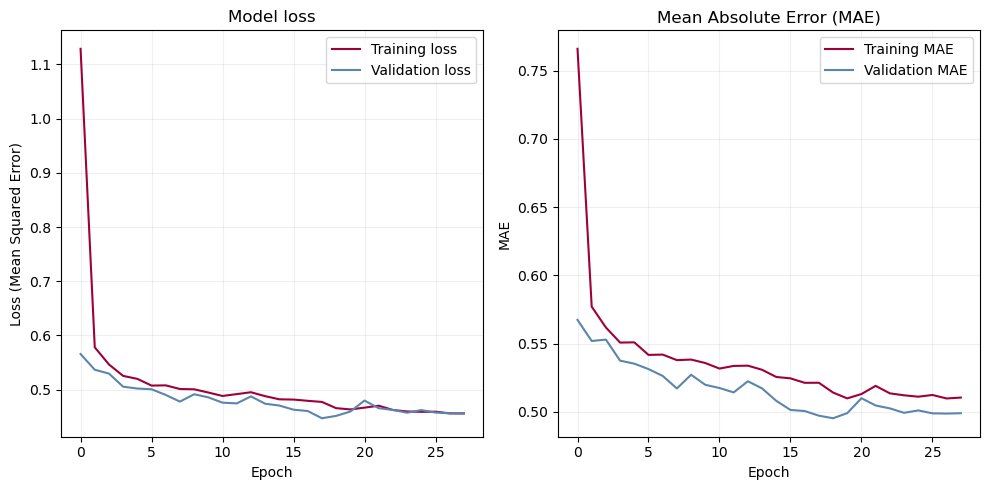

In [17]:
# Set up model callbacks
epochs = 100
callbacks_mag = architectures.callbacks_setup(model_tag='lstm_regression_magnitude', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['source_magnitude'])
train_dataset_mag, val_dataset_mag, test_dataset_mag = training_utils.prepare_datasets(imgs=envelopes_earthquakes_only, labels=labels, batch_size=32)
input_shape = (envelopes_earthquakes_only.shape[1], envelopes_earthquakes_only.shape[2])
model_magnitude = build_compile_regression_lstm(input_shape=input_shape, learning_rate=1e-4, loss='mse', metrics=['mae'])
model_magnitude_history = model_magnitude.fit(train_dataset_mag, epochs=epochs, callbacks=callbacks_mag, validation_data=val_dataset_mag)

# Evaluate model and plot results
training_utils.evaluate_regression_model(model_magnitude, test_dataset_mag, 'Source Magnitude', scaler=None)
training_utils.plot_training_history(model_magnitude_history)

In [139]:
def evaluate_regression_model(trained_model, train_dataset, test_dataset, target_variable_name, scaler=None):
    # Fetch labels
    train_labels = []
    for images, labels in train_dataset:
        train_labels.append(np.array(labels))
    train_labels = np.concatenate(train_labels)

    test_labels = []
    for images, labels in test_dataset:
        test_labels.append(np.array(labels))
    test_labels = np.concatenate(test_labels)

    # Calculate baseline error
    baseline_residuals = test_labels - np.mean(train_labels)
    baseline_mse = np.mean(baseline_residuals**2)
    baseline_mae = np.mean(np.abs(baseline_residuals))

    # Evaluate model
    print('Evaluating model on test dataset')
    test_results = trained_model.evaluate(test_dataset, verbose=1)
    print(f'Test data MSE: {test_results[0]}')
    print(f'Test data MAE: {test_results[1]}')

    print('Getting predictions')
    predicted = trained_model.predict(test_dataset)

    if scaler:
        test_labels = scaler.inverse_transform(test_labels)
        predicted = scaler.inverse_transform(predicted)
        print(predicted)

    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12,6), gridspec_kw={'width_ratios':[1,1,2]})
    baseline_metrics = [baseline_mse, baseline_mae]
    model_metrics = [test_results[0], test_results[1]]
    bar_container1 = ax1.bar(1-0.2, baseline_metrics[0], color='xkcd:cranberry', width=0.35, label='Baseline')
    bar_container2 = ax1.bar(1+0.2, model_metrics[0], color='xkcd:french blue', width=0.35, label='Model')
    ax1.bar_label(bar_container1, fmt='{:.2f}')
    ax1.bar_label(bar_container2, fmt='{:.2f}')
    ax1.set_xlim([0.4,1.6])
    ax1.set_xticks([1-0.2, 1+0.2])
    ax1.set_xticklabels(['Baseline\nmodel','Model'])
    ax1.set_title('Model vs. baseline MSE')
    ax1.set_ylabel('Mean squared error (MSE)')
    bar_container3 = ax2.bar(1-0.2, baseline_metrics[1], color='xkcd:cranberry', width=0.35, label='Baseline')
    bar_container4 = ax2.bar(1+0.2, model_metrics[1], color='xkcd:french blue', width=0.35, label='Model')
    ax2.bar_label(bar_container3, fmt='{:.2f}')
    ax2.bar_label(bar_container4, fmt='{:.2f}')
    ax2.set_xlim([0.4,1.6])
    ax2.set_xticks([1-0.2, 1+0.2])
    ax2.set_xticklabels(['Baseline\nmodel','Model'])
    ax2.set_ylabel('Mean absolute error (MAE)')
    ax2.set_title('Model vs. baseline MAE')
    plot_max = max(test_labels.max(), predicted.max())
    plot_min = min(-0.5, test_labels.min(), predicted.min())
    ax3.scatter(test_labels, predicted, color='xkcd:french blue', alpha=0.05)
    ax3.plot([plot_min*0.9,plot_max*1.1], [plot_min*0.9,plot_max*1.1], color='black', linestyle='--')
    ax3.set_ylabel('Predicted value')
    ax3.set_xlabel('Observed value')
    ax3.set_title(f'Model results: {target_variable_name}')
    ax3.set_xlim([plot_min*0.9, plot_max*1.1])
    ax3.set_ylim([plot_min*0.9, plot_max*1.1])
    ax3.grid(True, alpha=0.2, zorder=5)
    plt.tight_layout()
    plt.show()

Epoch 1/10


/opt/miniconda3/envs/earthquake-detection/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1043/1043 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 455221.7812 - mae: 651.0938 - val_loss: 346038.1562 - val_mae: 561.2573 - learning_rate: 1.0000e-04
Epoch 2/10
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 275346.6875 - mae: 489.7339 - val_loss: 103448.3594 - val_mae: 268.5541 - learning_rate: 1.0000e-04
Epoch 3/10
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 73262.4609 - mae: 219.5531 - val_loss: 33538.0820 - val_mae: 154.6196 - learning_rate: 1.0000e-04
Epoch 4/10
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 34274.8086 - mae: 154.8502 - val_loss: 21901.7832 - val_mae: 120.1556 - learning_rate: 1.0000e-04
Epoch 5/10
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20334.5215 - mae: 112.2393 - val_loss: 10850.7217 - val_mae: 78.0953 - learning_rate: 1.0000e-04
Epoch 6/10
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 13462.6416 - mae: 88.1316 - val_loss: 8605.8926 - val_mae: 66.6473 - learning_rate: 1.0000e-04
Epoch 7/10
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/st

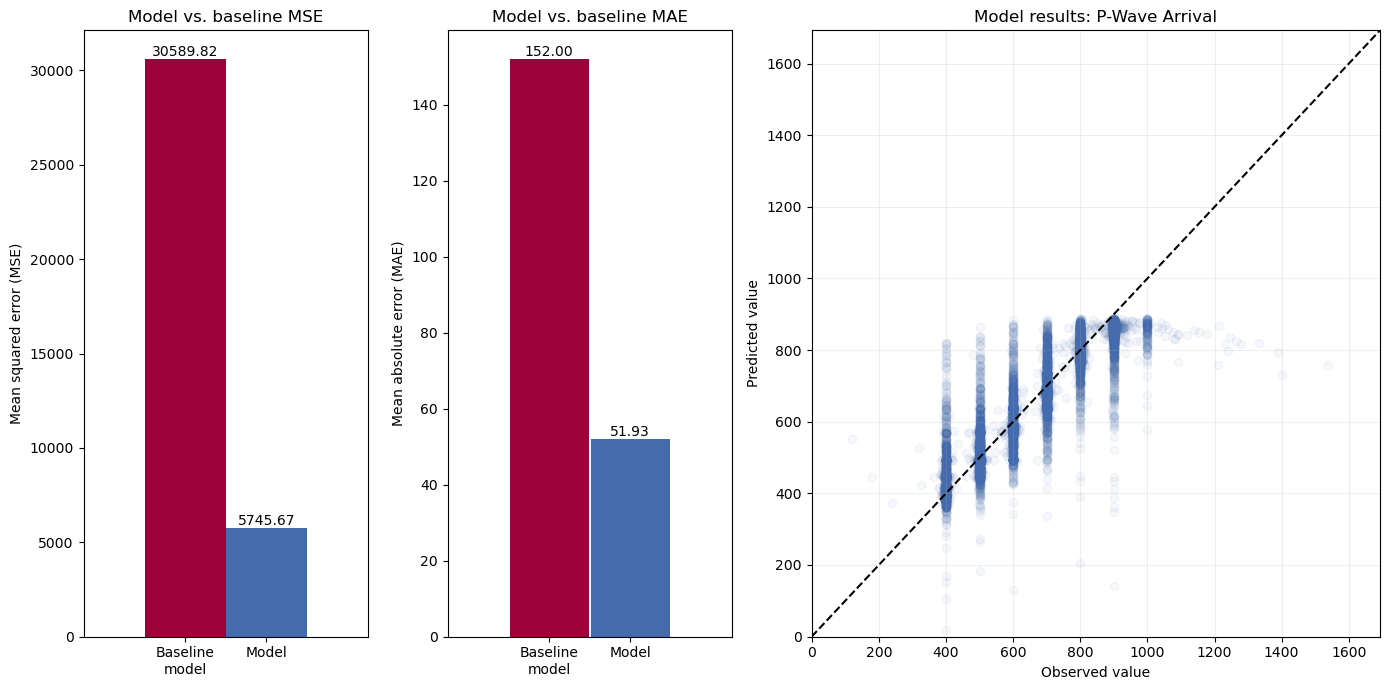

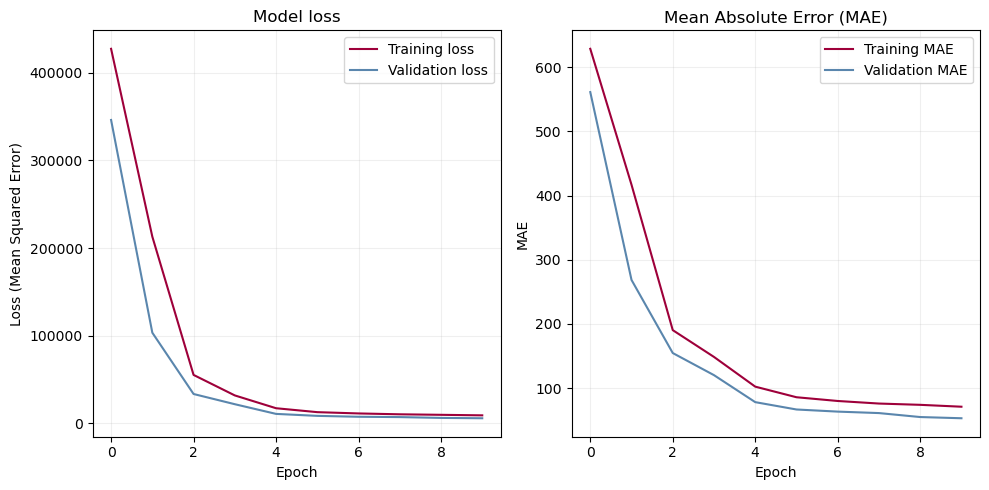

In [130]:
# Set up model callbacks
epochs = 10
callbacks_pwave = architectures.callbacks_setup(model_tag='lstm_regression_pwave', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['p_arrival_sample'])
train_dataset_pwave, val_dataset_pwave, test_dataset_pwave = training_utils.prepare_datasets(imgs=envelopes_earthquakes_only, labels=labels, batch_size=32)
input_shape = (envelopes_earthquakes_only.shape[1], envelopes_earthquakes_only.shape[2])
model_pwave = build_compile_regression_lstm(input_shape=input_shape, learning_rate=1e-4, loss='mse', metrics=['mae'])
model_pwave_history = model_pwave.fit(train_dataset_pwave, epochs=epochs, callbacks=callbacks_pwave, validation_data=val_dataset_pwave)

# Evaluate model and plot results
evaluate_regression_model(model_pwave, train_dataset_pwave, test_dataset_pwave, 'P-Wave Arrival', scaler=None)
training_utils.plot_training_history(model_pwave_history)

Epoch 1/5


/opt/miniconda3/envs/earthquake-detection/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1043/1043 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2131676.0000 - mae: 1326.5840 - val_loss: 1932373.1250 - val_mae: 1254.8514 - learning_rate: 1.0000e-04
Epoch 2/5
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1809192.8750 - mae: 1193.6500 - val_loss: 1320473.5000 - val_mae: 978.5023 - learning_rate: 1.0000e-04
Epoch 3/5
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1167340.2500 - mae: 879.8911 - val_loss: 690674.4375 - val_mae: 600.7914 - learning_rate: 1.0000e-04
Epoch 4/5
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 615705.8125 - mae: 540.3394 - val_loss: 379344.6250 - val_mae: 410.4355 - learning_rate: 1.0000e-04
Epoch 5/5
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 362962.0938 - mae: 386.3203 - val_loss: 204481.8281 - val_mae: 235.6082 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.
Evaluating model on test dataset
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 212820.4844 - mae: 238.8580
Test data MSE: 222421.1093

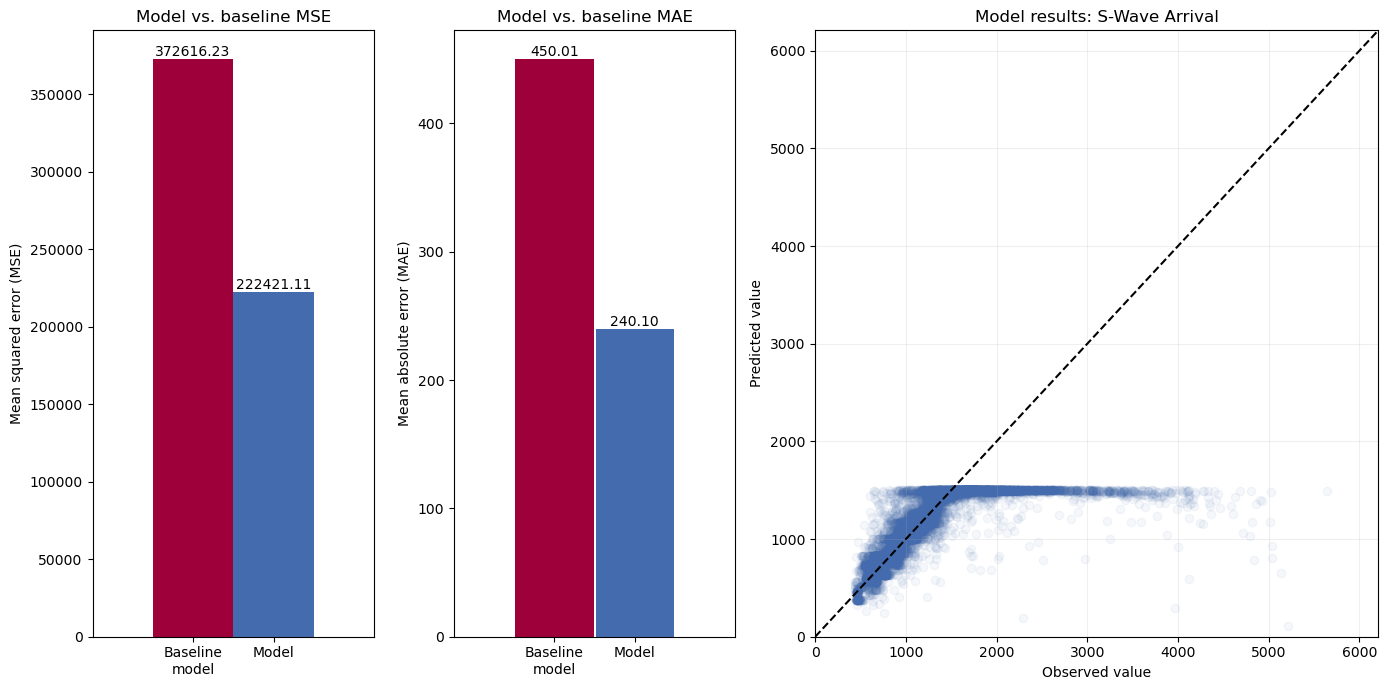

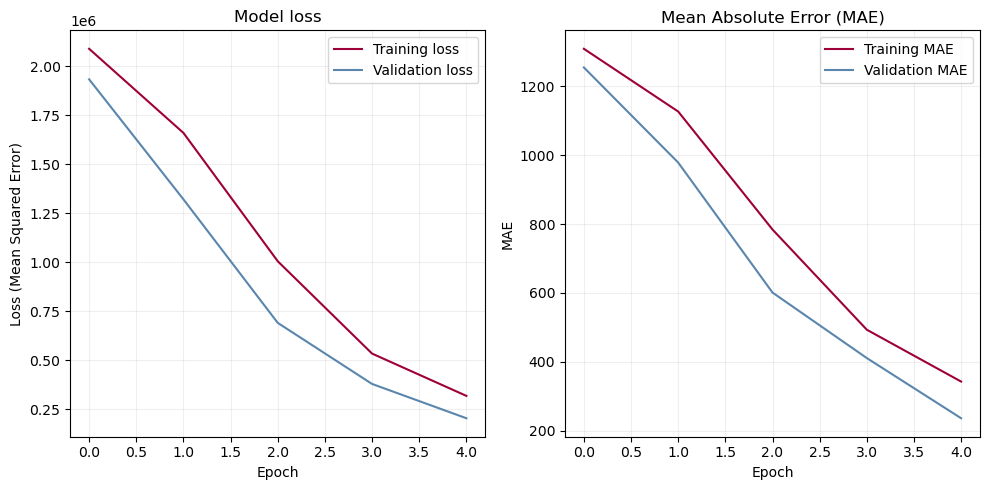

In [133]:
# Set up model callbacks
epochs = 5
callbacks_swave = architectures.callbacks_setup(model_tag='lstm_regression_swave', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['s_arrival_sample'])
train_dataset_swave, val_dataset_swave, test_dataset_swave = training_utils.prepare_datasets(imgs=envelopes_earthquakes_only, labels=labels, batch_size=32)
input_shape = (envelopes_earthquakes_only.shape[1], envelopes_earthquakes_only.shape[2])
model_swave = build_compile_regression_lstm(input_shape=input_shape, learning_rate=1e-4, loss='mse', metrics=['mae'])
model_swave_history = model_swave.fit(train_dataset_swave, epochs=epochs, callbacks=callbacks_swave, validation_data=val_dataset_swave)

# Evaluate model and plot results
evaluate_regression_model(model_swave, train_dataset_swave, test_dataset_swave, 'S-Wave Arrival', scaler=None)
training_utils.plot_training_history(model_swave_history)